# Imports

In [1]:
# Libraries 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns
import importlib

# Python files
import functions_nn

In [2]:
importlib.reload(functions_nn)
from functions_nn import *

# Load Data

In [3]:
df = pd.read_csv("macro_monthly_clean.csv")

# Change from object to datetime, set as index
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

# Model

## Configs

In [4]:
# Specify target variable and features
features = ['unrate', 'psr', 'm2', 'dspic', 'pce', 'ir', 'ffer', 'indpro', 'ccpi']
target = "unrate"

# Specify input and output length
input_sequence_length = 24
output_sequence_length = 1

## Fine tune data

In [5]:
# From df prepare the dataframe for use
arr_features_unscaled, arr_target_unscaled, df_features = prepare_data(df, features, target)
index_target = df_features.columns.get_loc("unrate") # Find index of the target variable column

# Choose the train data
train_data_length = df.shape[0] - df[df.index.year == 2021].shape[0]

# Select the x axis values for the actual vs. pred graph
x_values = df.index[train_data_length:]


In [6]:
# Scale each feature to a range between 0 and 1
scaler_train = MinMaxScaler()
arr_features_scaled = scaler_train.fit_transform(arr_features_unscaled)
    
# Create a separate scaler for a single column
scaler_pred = MinMaxScaler()
arr_target_scaled = scaler_pred.fit_transform(arr_target_unscaled)   

# Create the training and test data
train_data = arr_features_scaled[:train_data_length, :]
test_data = arr_features_scaled[train_data_length - input_sequence_length:, :]
test_data.shape


(34, 9)

In [7]:
# Generate training data and test data
x_train, y_train = partition_dataset(input_sequence_length, output_sequence_length, train_data, index_target)
x_test, y_test = partition_dataset(input_sequence_length, output_sequence_length, test_data, index_target)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(456, 24, 9) (456, 1)
(10, 24, 9) (10, 1)


## Train model

In [8]:
# Configs
epochs = 100
batch_size = 32
patience = 10
num_runs = 30

In [9]:
model = create_lstm_model("complex", x_train, output_sequence_length)

# Initialize variables to keep track of the best model and its performance
best_model = None
best_mape = float('inf')  # Initialize with a high value
best_mae = float('inf')   # Initialize with a high value
best_mse = float('inf')   # Initialize with a high value
best_predictions = None   # Initialize with None
best_train_loss = []      # Initialize with a high value
best_val_loss = []        # Initialize with a high value

for run in range(num_runs):
    # Create and compile your model here
    
    # Train the model
    history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), callbacks=[EarlyStopping(patience=10)])

    # Get the predicted values
    y_pred_scaled = model.predict(x_test)

    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled)
    y_test_unscaled = scaler_pred.inverse_transform(y_test).reshape(-1, output_sequence_length)

    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(y_test_unscaled, y_pred)

    # Mean Squared Error (MSE)
    MSE = mean_squared_error(y_test_unscaled, y_pred)

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred) / y_test_unscaled))) * 100

    print(f'Run {run + 1}: Median Absolute Error (MAE): {np.round(MAE, 2)}')
    print(f'Run {run + 1}: Mean Squared Error (MSE): {np.round(MSE, 2)}')
    print(f'Run {run + 1}: Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

    # Check if this run has the best MAPE so far
    if MAPE < best_mape:
        best_mape = MAPE
        best_mae = MAE
        best_mse = MSE
        best_model = model  # Save the best model
        best_predictions = y_pred  # Save the best predictions
        best_train_loss = history.history['loss']     # Save the training loss of the best run
        best_val_loss = history.history['val_loss']    # Save the validation loss of the best run

# After all runs, you can use best_model for predictions or further evaluation
# Example: y_pred_best = best_model.predict(x_test)

# Print the best MAE, MSE, MAPE, training loss, and validation loss
print(f'Best MAE: {np.round(best_mae, 2)}')
print(f'Best MSE: {np.round(best_mse, 2)}')
print(f'Best MAPE: {np.round(best_mape, 2)} %')


Epoch 1/100
15/15 [==============================] - 4s 107ms/step - loss: 0.0272 - val_loss: 0.0240
Epoch 2/100
15/15 [==============================] - 1s 64ms/step - loss: 0.0085 - val_loss: 0.0390
Epoch 3/100
15/15 [==============================] - 1s 64ms/step - loss: 0.0070 - val_loss: 0.0092
Epoch 4/100
15/15 [==============================] - 1s 64ms/step - loss: 0.0057 - val_loss: 0.0261
Epoch 5/100
15/15 [==============================] - 1s 64ms/step - loss: 0.0059 - val_loss: 0.0106
Epoch 6/100
15/15 [==============================] - 1s 64ms/step - loss: 0.0056 - val_loss: 0.0027
Epoch 7/100
15/15 [==============================] - 1s 67ms/step - loss: 0.0050 - val_loss: 0.0101
Epoch 8/100
15/15 [==============================] - 1s 69ms/step - loss: 0.0046 - val_loss: 0.0056
Epoch 9/100
15/15 [==============================] - 1s 65ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 10/100
15/15 [==============================] - 1s 64ms/step - loss: 0.0042 - val_loss: 0.001

# Results

## Plot - loss

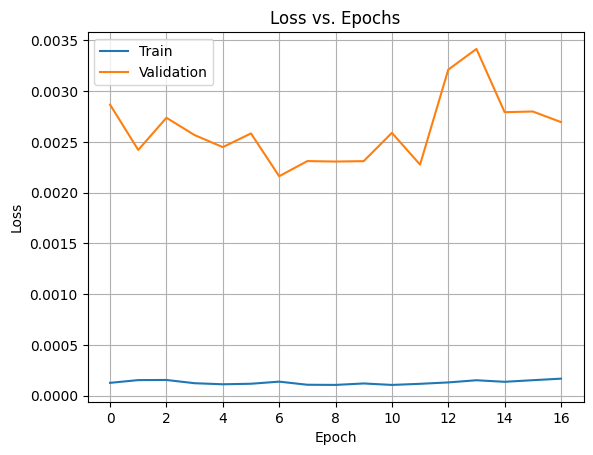

In [10]:
plt.plot(best_train_loss, label='Train')
plt.plot(best_val_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.savefig("loss.png")
plt.show()

## Plot - Actual vs. Predicted

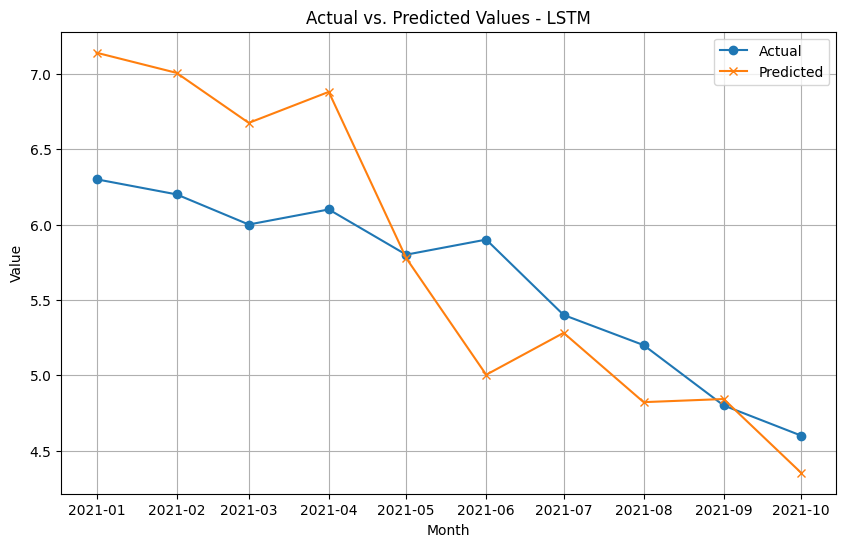

In [11]:
# Create a range of indices for the x-axis
indices = range(len(y_test_unscaled))

# Plot the actual values (y_test_unscaled) vs. predicted values (y_pred)
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_test_unscaled, label='Actual', marker='o')
plt.plot(x_values, best_predictions, label='Predicted', marker='x')
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values - LSTM')
plt.legend()
plt.grid(True)
plt.savefig("actualvspredicted.png")
plt.show()

In [12]:
# Save best_mae, best_mse, and best_mape in a text file
with open('model_metrics.txt', 'w') as file:
    file.write(f'Best MAE: {np.round(best_mae, 2)}\n')
    file.write(f'Best MSE: {np.round(best_mse, 2)}\n')
    file.write(f'Best MAPE: {np.round(best_mape, 2)} %\n')